In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [3]:
GCS_DS_PATH = r"C:\Users\91909\Desktop\DATA SCIENCE\DATA\Petals_to_Metal"
data_dir = GCS_DS_PATH + "/tfrecords-jpeg-192x192"

In [4]:
img_height, img_width = 192, 192
batch_size =128

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [img_height, img_width, 3])
    return image

In [6]:
def read_tfrecord(example, labeled=True):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.one_hot(example['class'], 104)
        return image, label
    return image, example['id']

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = dataset.with_options(ignore_order)
    return dataset.map(lambda x: read_tfrecord(x, labeled), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
train_files = tf.io.gfile.glob(data_dir + '/train/*.tfrec')
val_files = tf.io.gfile.glob(data_dir + '/val/*.tfrec')
test_files = tf.io.gfile.glob(data_dir + '/test/*.tfrec')

In [8]:
train_dataset = load_dataset(train_files).repeat().shuffle(462).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = load_dataset(val_files).batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = load_dataset(test_files, labeled=False, ordered=True).batch(batch_size)

In [10]:
def count_dataset_images(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    count = sum(1 for _ in dataset)
    return count

# Count the number of training and test images
train_images = count_dataset_images(train_files)
test_images = count_dataset_images(test_files)

print(f'Total training images: {train_images}')
print(f'Total test images: {test_images}')

Total training images: 12753
Total test images: 7382


ValueError: can only convert an array of size 1 to a Python scalar

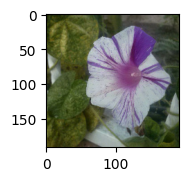

In [17]:
def plot_images(images, labels, CLASSES):
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, 6, i + 1)  # Adjust grid size as needed
        plt.imshow(images[i])
        plt.title(CLASSES[int(labels[i])])
        plt.axis('off')
    plt.show()

# Fetch a batch of images and labels
for image_batch, label_batch in train_dataset.take(1):
    # Convert to numpy arrays
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

    # Define class names (adjust as needed)
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',     # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

    # Plot images
plot_images(image_batch, label_batch, CLASSES)